# 필요한 Library import 

### torchtext
torchText 는 자연어 처리에서 아래 과정을 쉽게 도와준다.
- 토크나이징 (Tokenization)
- 단어장 생성 (Build Vocabulary)
- 토큰의 수치화 (Numericalize all tokens)
- 데이터 로더 생성 (Create Data Loader)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchtext.legacy import data 
from torchtext import datasets
import random
import numpy as np

from konlpy.tag import Mecab
mecab = Mecab()

# 랜덤 시드 고정

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Tokenizer 수정

In [3]:
KERNEL_SIZE = [3,4,5]

def tokenizer(text):
    token = mecab.morphs(text) 
    if len(token) < max(KERNEL_SIZE): 
        for i in range(0, max(KERNEL_SIZE)-len(token)):
            token.append('<PAD>') # 커널 사이즈 보다 문장의 길이가 작은 경우 에러 방지
    return token

# 필드 정의 및 데이터 셋 만들기

In [4]:
REVIEW = data.Field(tokenize = tokenizer, batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

# {csv컬럼명 : (데이터 컬럼명, Field이름)} / id는 사용 x
fields = {'review': ('review', REVIEW), 'label': ('label', LABEL)}

In [5]:
train_data, test_data = data.TabularDataset.splits(path = 'data', # 데이터 파일 경로 
                                                  train = 'train_data.csv',
                                                  test = 'test_data.csv',
                                                  format = 'csv', # 데이터 파일 형식
                                                  fields = fields) 

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [6]:
print('훈련 샘플의 개수 : {}'.format(len(train_data)))
print('테스트 샘플의 개수 : {}'.format(len(test_data)))
print(vars(train_data[3]))

훈련 샘플의 개수 : 104996
테스트 샘플의 개수 : 49997
{'review': ['너무', '좋', '았', '다', '.', '말', '이', '필요', '없', '음', '.', '계속', '보', '고', '싶', '다'], 'label': '1'}


# 단어 집합(Vocabulary) 만들기
**\<unk>** : 인코딩 과정에서 사전에 없는 단어는 전부 이 토큰의 인덱스로 인코딩 <br>
**\<pad>** : Padding (입력 데이터를 배치로 처리하려면, 배치 내의 모든 데이터가 같은 사이즈를 가져야 함)

In [7]:
MAX_VOCAB_SIZE = 25000 # 단어 집합의 최대 크기

REVIEW.build_vocab(train_data,
#                    min_freq = 3, # 단어의 최소 등장 빈도 조건
                   max_size = MAX_VOCAB_SIZE, 
                   vectors = 'fasttext.simple.300d', # 한글 지원
                   unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

.vector_cache/wiki.simple.vec: 293MB [02:03, 2.37MB/s]                          
100%|████████████████████████████████| 111051/111051 [00:09<00:00, 12287.15it/s]


In [8]:
print('단어 집합의 크기 : {}'.format(len(REVIEW.vocab)))
# print(REVIEW.vocab.stoi) # 생성된 단어 집합 내 단어 확인 

단어 집합의 크기 : 25002


In [9]:
REVIEW.vocab.vectors.shape

torch.Size([25002, 300])

# 데이터 로더 생성

In [10]:
BATCH_SIZE = 128

# BucketIterator : 모든 텍스트 작업을 일괄로 처리하고 단어를 인덱스 숫자로 변환 하는것을 도움 
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.review), # 길이가 유사한 것을 일괄 처리하고, 패딩을 최소화하기위해 길이로 정렬
    sort_within_batch = True) # 오름차순 정렬

# Model
##  [CNN을 이용한 자연어 처리](https://wikidocs.net/80437)
 : 1D CNN - 커널 사이즈 : [ n, embedding_dimension ]
- 커널의 너비가 임베딩 벡터 차원 -> 커널이 2D CNN 때와 달리 너비 방향으로는 더 이상 움직일 곳이 없음
- `1D Convolution` + `Pooling`

### 1D Convolution 
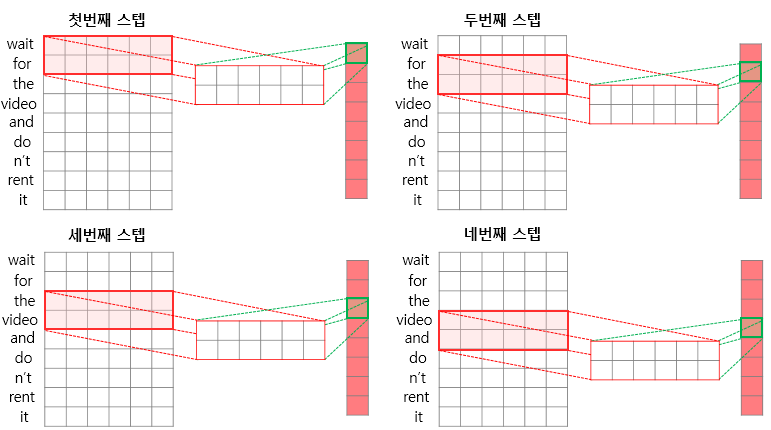

<br>

###  Max-Pooling
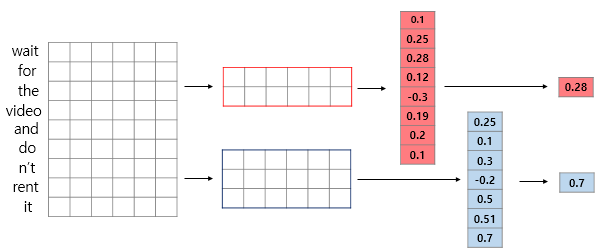

논문 : [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882)

In [11]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_kernels, kernel_sizes, output_dim, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings = vocab_size, # 임베딩을 할 단어들의 개수 (단어 집합의 크기)
                                      embedding_dim = embedding_dim, # 임베딩 할 벡터의 차원 (하이퍼파라미터)
                                      padding_idx = pad_idx) # 패딩을 위한 토큰의 인덱스
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, # input channel수 ( ex RGB 이미지 = 3 )
                                              out_channels = n_kernels, # convolution에 의해 생성될 channel의 수
                                              kernel_size = (ksize, embedding_dim)) # ksize만 변화. embedding_dim은 고정
                                    for ksize in kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes)*n_kernels, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, review):
        embedded = self.embedding(review)
        embedded = embedded.unsqueeze(1) # 특정 위치에 1인 차원을 추가 <-> squeeze : 1인 차원을 제거
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        res = self.fc(cat)
        return self.fc(cat)

In [12]:
# 모델 선언
INPUT_DIM = len(REVIEW.vocab)
EMBEDDING_DIM = 300
N_KERNELS = 100
KERNEL_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = REVIEW.vocab.stoi[REVIEW.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_KERNELS, KERNEL_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

print('모델 파라미터 수 :', sum(param.numel() for param in model.parameters() if param.requires_grad))

모델 파라미터 수 : 7861201


In [13]:
# 사전 훈련된 단어 벡터 불러오기
pretrained_weight = REVIEW.vocab.vectors
print(pretrained_weight.shape, model.embedding.weight.data.shape)
print(model.embedding.weight.data.copy_(pretrained_weight))

torch.Size([25002, 300]) torch.Size([25002, 300])
tensor([[ 1.9269,  1.4873,  0.9007,  ..., -2.1268, -0.1341, -1.0408],
        [ 0.7694,  2.5574,  0.5716,  ..., -0.9120,  0.3682,  0.7050],
        [ 0.0569, -0.0520,  0.2733,  ..., -0.0695, -0.1606, -0.0989],
        ...,
        [ 0.8510,  0.7696,  0.5487,  ...,  1.6145, -1.1287, -0.0815],
        [ 1.1613, -0.3453,  0.4837,  ..., -0.6227, -0.5946, -1.9983],
        [ 0.2382, -0.8192,  0.1765,  ..., -0.7145, -0.2008,  1.0121]])


In [14]:
UNK_IDX = REVIEW.vocab.stoi[REVIEW.unk_token]

# unk, pad token -> 0 처리 
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# Train

In [15]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss() # BCELoss + sigmoid

In [16]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds==y).float()
    acc = correct.sum() / len(correct)
    return acc

In [17]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.review).squeeze(1) # batchsize 크기 텐서 (output_dim = 1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.review).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'MovieSentimentAnalysis.pt') # 모델 저장
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 49s
	Train Loss: 0.461 | Train Acc: 77.67%
	 Val. Loss: 0.367 |  Val. Acc: 83.74%
Epoch: 02 | Epoch Time: 2m 48s
	Train Loss: 0.346 | Train Acc: 85.01%
	 Val. Loss: 0.343 |  Val. Acc: 85.16%
Epoch: 03 | Epoch Time: 2m 55s
	Train Loss: 0.294 | Train Acc: 87.73%
	 Val. Loss: 0.360 |  Val. Acc: 84.73%
Epoch: 04 | Epoch Time: 2m 51s
	Train Loss: 0.251 | Train Acc: 89.86%
	 Val. Loss: 0.344 |  Val. Acc: 85.62%
Epoch: 05 | Epoch Time: 2m 47s
	Train Loss: 0.215 | Train Acc: 91.48%
	 Val. Loss: 0.360 |  Val. Acc: 85.60%


# Test

In [21]:
model.load_state_dict(torch.load('MovieSentimentAnalysis.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.347 | Test Acc: 85.03%


In [69]:
def sentiment_predict(review, tokenizer, model):
    tokens = tokenizer(review) # 토큰화 
    idxes=[]
    
    # 각 단어를 정수로 변환
    for token in tokens:
        try:
            idxes.append(REVIEW.vocab[token])
        except KeyError: # 단어 집합에 없는 단어일 경우 <unk>로 대체
            idxes.append(vocab['<unk>'])
    idxes = torch.LongTensor(idxes)
    idxes = idxes.unsqueeze(0)
    predictions = torch.sigmoid(model(idxes).squeeze(1))
    if(predictions > 0.5):
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format(predictions.item() * 100))
    else:
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format((1-predictions.item())*100))

In [70]:
sentiment_predict('정말 대작입니다... 꼭 보세요', tokenizer, model)

98.59% 확률로 긍정 리뷰입니다.


In [71]:
sentiment_predict('제가 본 영화 중 최고였습니다..', tokenizer, model)

99.60% 확률로 긍정 리뷰입니다.


In [72]:
sentiment_predict('한번 더 볼 의향 100%!!', tokenizer, model)

83.35% 확률로 긍정 리뷰입니다.


In [73]:
sentiment_predict('돈 아깝다~~~', tokenizer, model)

99.48% 확률로 부정 리뷰입니다.



In [74]:
sentiment_predict('개 노잼... 보다가 중간에 나올뻔했다,,', tokenizer, model)

99.60% 확률로 부정 리뷰입니다.



In [75]:
sentiment_predict('영화를 이렇게 재미없게도 만들 수 있구나..', tokenizer, model)

97.73% 확률로 부정 리뷰입니다.

